# Module 3 - Modeling

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import logging

In [73]:
data = pd.read_csv(r"/home/raquel/zrive-ds/src/module_3/feature_frame.csv")

In [74]:
data.shape

(2880549, 27)

# Orders with more than 5 products

In [75]:
purchases = data[data["outcome"] == 1]
purchases = purchases.groupby("order_id").size().reset_index(name="n_products")
purch_5_prod = purchases[purchases["n_products"] >= 5]

In [76]:
len(purch_5_prod)

2603

The previous DataFrame contains the products purchased in each of the orders with more than 5 products. I complete the dataset with those products that have NOT been purchased in these baskets

In [77]:
purch_5_prod = data[data["order_id"].isin(purch_5_prod["order_id"])]
print(purch_5_prod.shape)

(2163953, 27)


# Preprocessing data

In [78]:
# Class imbalance
purch_5_prod["outcome"].value_counts(normalize=True)
# QUESTION: would be appropiate to study any technique to balance? which one?

outcome
0.0    0.985522
1.0    0.014478
Name: proportion, dtype: float64

In [79]:
# For a recommendation algorithm, I think it could be useful to create a feature that extracts the month of the purchase.
purch_5_prod = purch_5_prod.assign(
    created_at=lambda x: pd.to_datetime(x.created_at)
).assign(month_created=lambda x: x.created_at.dt.month)
purch_5_prod.head(2)

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,month_created
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,10
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,10


# Train-Val-Test split

I study the temporal component of the orders because if it is strong, I need to consider that in production it will work in such a way that I only have information from today backward.
Besides, all the information of the same order will be in the same train/valid/test subset.
 

<Axes: xlabel='order_date'>

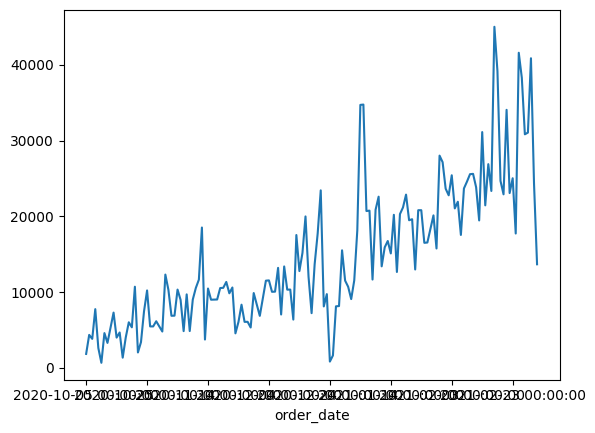

In [80]:
purch_5_prod.groupby("order_date").size().plot(kind="line")

QUESTION: This graph shows the temporal component of the number of orders in a day, but it doesn't show the temporal component of the products that are bought. It can happen that the number of orders changes over time, but the products do not, right?

In [81]:
purch_5_prod = purch_5_prod.sort_values(by="order_date")
X = purch_5_prod.drop(columns="outcome")
y = purch_5_prod["outcome"]
# Split indices for 70%, 20%, 10%
train_end = int(0.7 * len(X))
val_end = int(0.9 * len(X))
X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
X_test, y_test = X.iloc[val_end:], y.iloc[val_end:]

print(
    f"Train orders amount: {len(X_train['order_id'].unique())}\n"
    f"Valid orders amount: {len(X_val['order_id'].unique())}\n"
    f"Test orders amount: {len(X_test['order_id'].unique())}"
)

Train orders amount: 1928
Valid orders amount: 519
Test orders amount: 229


# Baseline

In [82]:
# Without predictive power
info_cols = ["variant_id", "order_id", "user_id", "created_at", "order_date"]
label_col = "outcome"
feature_cols = [
    col for col in purch_5_prod.columns if col not in info_cols + [label_col]
]
# Breaking down the features
categorical_cols = ["product_type", "vendor", "month_created"]
binary_cols = ["ordered_before", "abandoned_before", "active_snoozed", "set_as_regular"]
numerical_cols = [
    col for col in feature_cols if col not in categorical_cols + binary_cols
]

For the baseline, I consider a rule with the variable with the highest correlation (this has sense as it is a linear model) and whether the product has been purchased before 


In [83]:
# Higuest correlation
corr_with_label = data[numerical_cols + [label_col]].corr()[label_col].drop(label_col)
max_corr, max_corr_value = corr_with_label.abs().idxmax(), corr_with_label.max()
print(f"Most correlated feature: {max_corr}")
print(f"Value: {max_corr_value}")

Most correlated feature: global_popularity
Value: 0.16262765958759298


In [84]:
# Baseline equation
w1, w2 = 0.5, 0.3
y_pred_baseline = w1 * X_val["global_popularity"] + w2 * X_val["ordered_before"]

# Metrics

As it is a desbalanced problem I choose the precision-recall, with this curve I'm looking for understanding how to adjust the notifications to maximize effectiveness (sales) without sacrificing user satisfaction. 

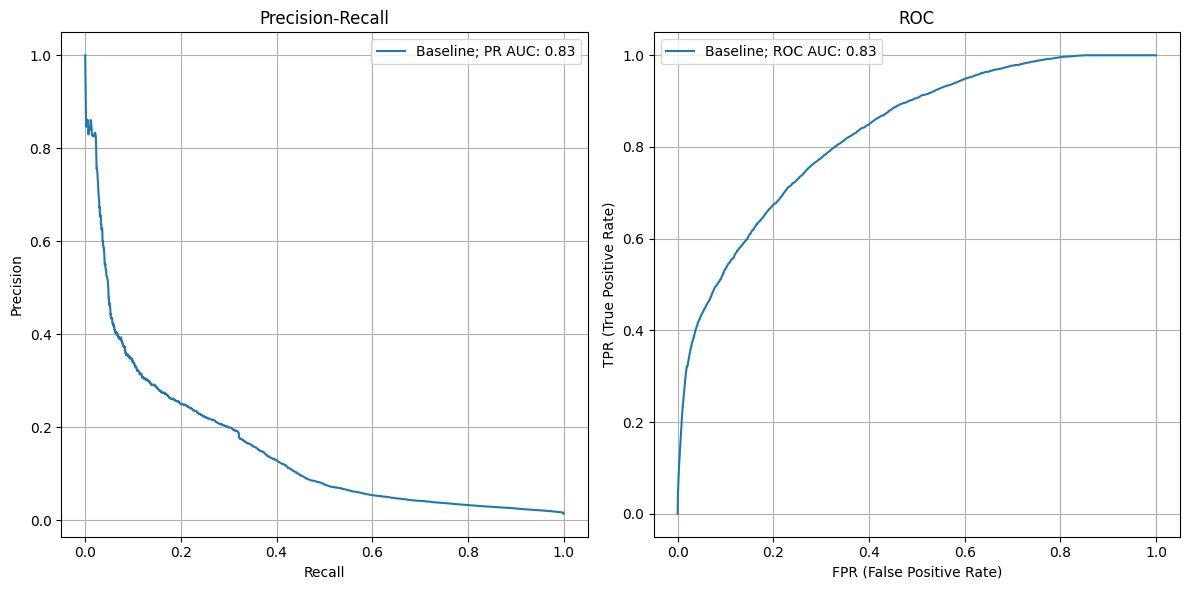

In [85]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))


w1, w2 = 0.5, 0.3

# Validation curves
y_val_baseline = w1 * X_val["global_popularity"] + w2 * X_val["ordered_before"]
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_baseline)
pr_auc = roc_auc_score(y_val, y_val_baseline)
ax1.plot(recall_val, precision_val, label=f"Baseline; PR AUC: {pr_auc:.2f}")
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_baseline)
roc_auc = roc_auc_score(y_val, y_val_baseline)
ax2.plot(fpr_val, tpr_val, label=f"Baseline; ROC AUC: {roc_auc:.2f}")


ax1.set_title("Precision-Recall")
ax1.set_xlabel("Recall")
ax1.set_ylabel("Precision")
ax1.grid()
ax1.legend()

ax2.set_title("ROC")
ax2.set_xlabel("FPR (False Positive Rate)")
ax2.set_ylabel("TPR (True Positive Rate)")
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()

I would be interested in calibrating my model in such a way that false positives have a minimal value (due to the high cost of incorrect notifications that generate dissatisfaction), even if that means sending fewer notifications and having less capacity to increase sales through this channel.

# Modelling

Vendor and product_type have a really hight cardinality so I'm going to ignore them by now.
But for the categorical encoding of the months, since they are an ordinal feature where the order is significant, I'm going to maintain the number of the month as I had used an Ordinal Encoder

In [86]:
train_cols = numerical_cols + binary_cols + ["month_created"]

To avoid overfitting, I’m going to use a loss function like Ridge that penalizes complexity

Ridge Regression

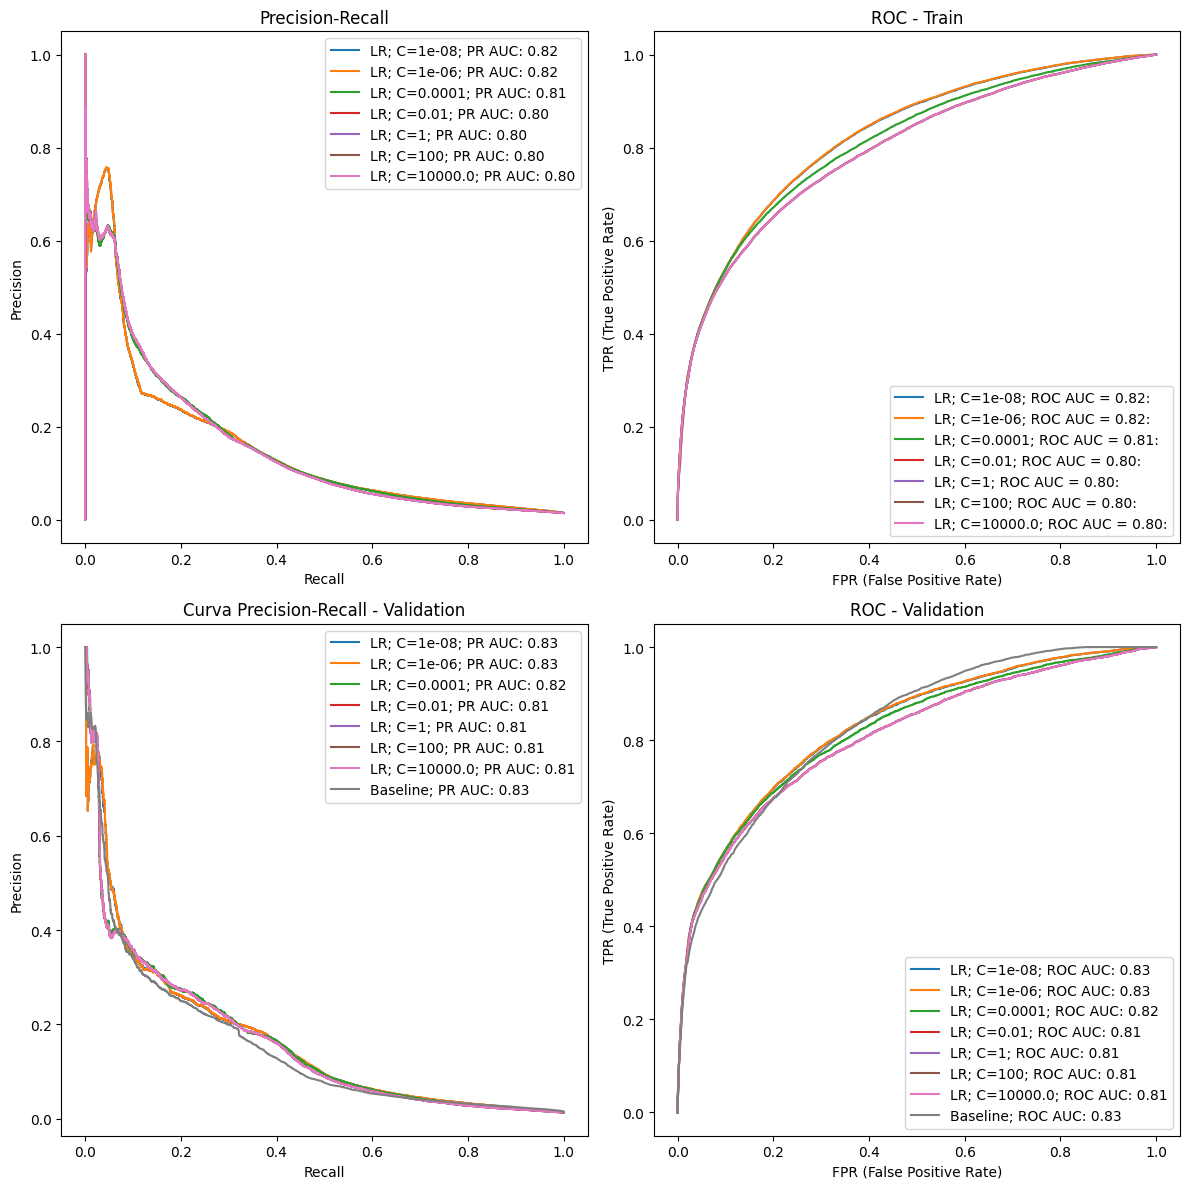

In [87]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
ax1, ax2, ax3, ax4 = axs.flatten()
cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4]
for c in cs:
    lr = make_pipeline(StandardScaler(), LogisticRegression(penalty="l2", C=c))
    # Training model
    lr.fit(X_train[train_cols], y_train)
    # Training curves
    train_proba = lr.predict_proba(X_train[train_cols])[
        :, 1
    ]  # va a estandarizar los datos con media y desviación del train
    precision_train, recall_train, _ = precision_recall_curve(y_train, train_proba)
    pr_auc = roc_auc_score(y_train, train_proba)
    ax1.plot(recall_train, precision_train, label=f"LR; C={c}; PR AUC: {pr_auc:.2f}")
    fpr_train, tpr_train, _ = roc_curve(y_train, train_proba)
    roc_auc = roc_auc_score(y_train, train_proba)
    ax2.plot(fpr_train, tpr_train, label=f"LR; C={c}; ROC AUC = {roc_auc:.2f}:")
    # Validation curves
    val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
    precision_val, recall_val, _ = precision_recall_curve(y_val, val_proba)
    pr_auc = roc_auc_score(y_val, val_proba)
    ax3.plot(recall_val, precision_val, label=f"LR; C={c}; PR AUC: {pr_auc:.2f}")
    fpr_val, tpr_val, _ = roc_curve(y_val, val_proba)
    roc_auc = roc_auc_score(y_val, val_proba)
    ax4.plot(fpr_val, tpr_val, label=f"LR; C={c}; ROC AUC: {roc_auc:.2f}")

# Adding Baseline validation

# Validation curves
y_val_baseline = w1 * X_val["global_popularity"] + w2 * X_val["ordered_before"]
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_baseline)
pr_auc = roc_auc_score(y_val, y_val_baseline)
ax3.plot(recall_val, precision_val, label=f"Baseline; PR AUC: {pr_auc:.2f}")
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_baseline)
roc_auc = roc_auc_score(y_val, y_val_baseline)
ax4.plot(fpr_val, tpr_val, label=f"Baseline; ROC AUC: {roc_auc:.2f}")


ax1.set_title("Precision-Recall")
ax1.set_xlabel("Recall")
ax1.set_ylabel("Precision")
ax1.legend()

ax2.set_title("ROC - Train")
ax2.set_xlabel("FPR (False Positive Rate)")
ax2.set_ylabel("TPR (True Positive Rate)")
ax2.legend()


ax3.set_title("Curva Precision-Recall - Validation")
ax3.set_xlabel("Recall")
ax3.set_ylabel("Precision")
ax3.legend()


ax4.set_title("ROC - Validation")
ax4.set_xlabel("FPR (False Positive Rate)")
ax4.set_ylabel("TPR (True Positive Rate)")
ax4.legend()

plt.tight_layout()
plt.show()

- For all values of C (ranging from 1e-8 to 1e4), I observe the same performance in both train and validation. This means that regardless of the value of alpha, overfitting does not occur. I will study Lasso, and if the same happens, regularization will not be used.
- The orange line is slightly different. In training, it performs better than the other colours because it has a peak where a recall of 0.08 achieves a precision of 0.75. However, these scores are not repeated in the validation set. The orange line in the validation set behaves similarly to the other regularizations.
- Another point is that the performance of the models are as the baseline

Lasso

/tmp/ipykernel_15503/118021244.py:62: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


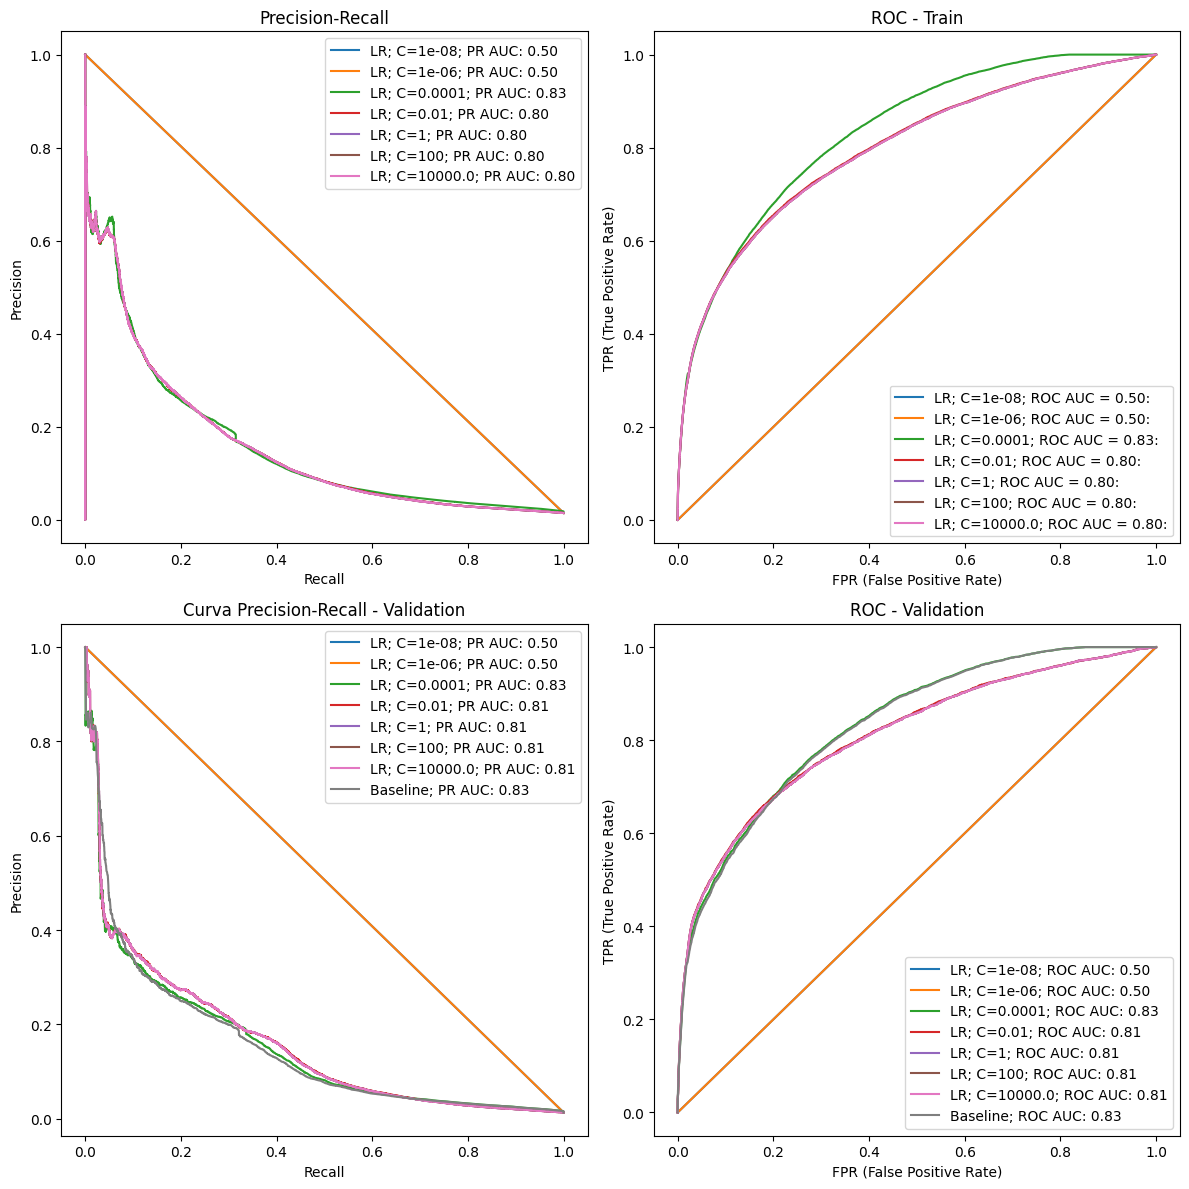

In [88]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
ax1, ax2, ax3, ax4 = axs.flatten()
cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4]
for c in cs:
    lr = make_pipeline(
        StandardScaler(), LogisticRegression(penalty="l1", C=c, solver="saga")
    )
    # Training model
    lr.fit(X_train[train_cols], y_train)
    # Training curves
    train_proba = lr.predict_proba(X_train[train_cols])[
        :, 1
    ]  # va a estandarizar los datos con media y desviación del train
    precision_train, recall_train, _ = precision_recall_curve(y_train, train_proba)
    pr_auc = roc_auc_score(y_train, train_proba)
    ax1.plot(recall_train, precision_train, label=f"LR; C={c}; PR AUC: {pr_auc:.2f}")
    fpr_train, tpr_train, _ = roc_curve(y_train, train_proba)
    roc_auc = roc_auc_score(y_train, train_proba)
    ax2.plot(fpr_train, tpr_train, label=f"LR; C={c}; ROC AUC = {roc_auc:.2f}:")
    # Validation curves
    val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
    precision_val, recall_val, _ = precision_recall_curve(y_val, val_proba)
    pr_auc = roc_auc_score(y_val, val_proba)
    ax3.plot(recall_val, precision_val, label=f"LR; C={c}; PR AUC: {pr_auc:.2f}")
    fpr_val, tpr_val, _ = roc_curve(y_val, val_proba)
    roc_auc = roc_auc_score(y_val, val_proba)
    ax4.plot(fpr_val, tpr_val, label=f"LR; C={c}; ROC AUC: {roc_auc:.2f}")

# Adding Baseline validation

# Validation curves
y_val_baseline = w1 * X_val["global_popularity"] + w2 * X_val["ordered_before"]
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_baseline)
pr_auc = roc_auc_score(y_val, y_val_baseline)
ax3.plot(recall_val, precision_val, label=f"Baseline; PR AUC: {pr_auc:.2f}")
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_baseline)
roc_auc = roc_auc_score(y_val, y_val_baseline)
ax4.plot(fpr_val, tpr_val, label=f"Baseline; ROC AUC: {roc_auc:.2f}")


ax1.set_title("Precision-Recall")
ax1.set_xlabel("Recall")
ax1.set_ylabel("Precision")
ax1.legend()

ax2.set_title("ROC - Train")
ax2.set_xlabel("FPR (False Positive Rate)")
ax2.set_ylabel("TPR (True Positive Rate)")
ax2.legend()


ax3.set_title("Curva Precision-Recall - Validation")
ax3.set_xlabel("Recall")
ax3.set_ylabel("Precision")
ax3.legend()


ax4.set_title("ROC - Validation")
ax4.set_xlabel("FPR (False Positive Rate)")
ax4.set_ylabel("TPR (True Positive Rate)")
ax4.legend()

plt.tight_layout()
plt.show()

- With large regularization, the model behaves randomly with an AUC of 0.5. There are only two outcomes: either all predictions are class 0 or all predictions are class 1.
-  In this case, the effect of regularization does not lead to an improvement in performance on the validation set for any C values; every case has the same performance as the training set. The only change is the precision heigth of the step, it is lower in the validation data. (QUESTION: as it is in validation where the step at recall = 0.01, means that the results in validation have more precision????????????????)
- The values are similar to Ridge
- For this reason, the model can be evaluated with Log Loss because it doesn´t overfit

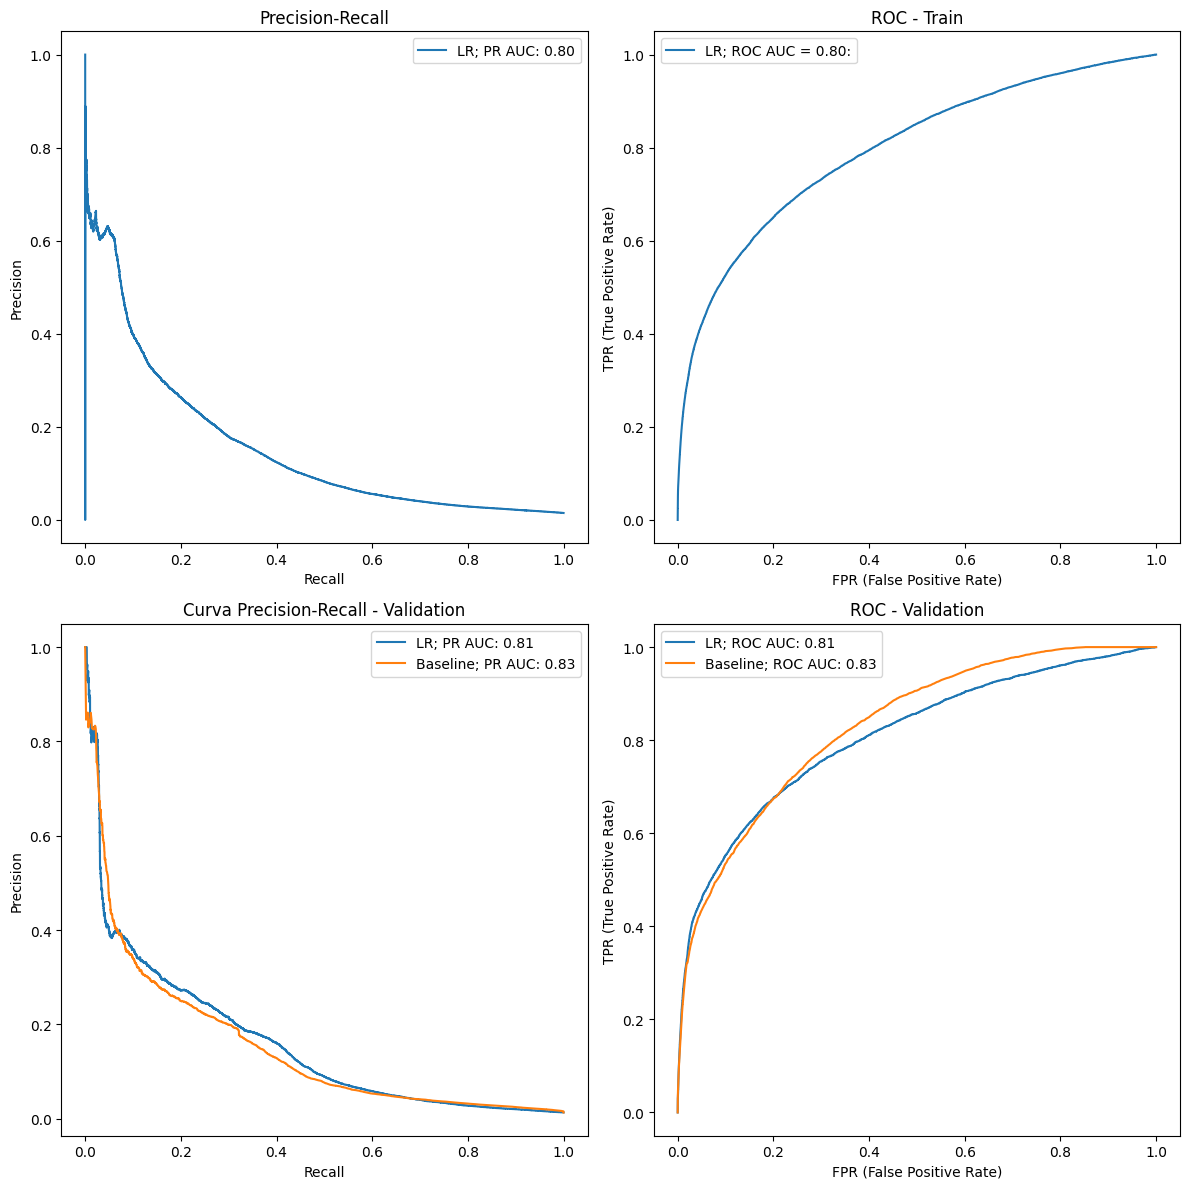

In [89]:
# Model with penalty log loss (no regularization)
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
ax1, ax2, ax3, ax4 = axs.flatten()


lr = make_pipeline(StandardScaler(), LogisticRegression(penalty=None, random_state=42))
# Training model
lr.fit(X_train[train_cols], y_train)
# Training curves
train_proba = lr.predict_proba(X_train[train_cols])[
    :, 1
]  # It will standardize the data using the mean and standard deviation from the training set.
precision_train, recall_train, _ = precision_recall_curve(y_train, train_proba)
pr_auc = roc_auc_score(y_train, train_proba)
ax1.plot(recall_train, precision_train, label=f"LR; PR AUC: {pr_auc:.2f}")
fpr_train, tpr_train, _ = roc_curve(y_train, train_proba)
roc_auc = roc_auc_score(y_train, train_proba)
ax2.plot(fpr_train, tpr_train, label=f"LR; ROC AUC = {roc_auc:.2f}:")
# Validation curves
val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
precision_val, recall_val, _ = precision_recall_curve(y_val, val_proba)
pr_auc = roc_auc_score(y_val, val_proba)
ax3.plot(recall_val, precision_val, label=f"LR; PR AUC: {pr_auc:.2f}")
fpr_val, tpr_val, _ = roc_curve(y_val, val_proba)
roc_auc = roc_auc_score(y_val, val_proba)
ax4.plot(fpr_val, tpr_val, label=f"LR; ROC AUC: {roc_auc:.2f}")

# Adding Baseline validation

# Validation curves
y_val_baseline = w1 * X_val["global_popularity"] + w2 * X_val["ordered_before"]
precision_val, recall_val, thresholds = precision_recall_curve(y_val, y_val_baseline)
pr_auc = roc_auc_score(y_val, y_val_baseline)
ax3.plot(recall_val, precision_val, label=f"Baseline; PR AUC: {pr_auc:.2f}")
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_baseline)
roc_auc = roc_auc_score(y_val, y_val_baseline)
ax4.plot(fpr_val, tpr_val, label=f"Baseline; ROC AUC: {roc_auc:.2f}")


ax1.set_title("Precision-Recall")
ax1.set_xlabel("Recall")
ax1.set_ylabel("Precision")
ax1.legend()

ax2.set_title("ROC - Train")
ax2.set_xlabel("FPR (False Positive Rate)")
ax2.set_ylabel("TPR (True Positive Rate)")
ax2.legend()


ax3.set_title("Curva Precision-Recall - Validation")
ax3.set_xlabel("Recall")
ax3.set_ylabel("Precision")
ax3.legend()


ax4.set_title("ROC - Validation")
ax4.set_xlabel("FPR (False Positive Rate)")
ax4.set_ylabel("TPR (True Positive Rate)")
ax4.legend()

plt.tight_layout()
plt.show()

- In the ROC curve, if we examine the AUC value, it is greater for the baseline than for the Logistic Regression (LR) model. However, upon closer inspection, since this is an imbalanced problem, the latter part of the curve is not truly representative. Therefore, in the initial part of the curve, up to an FPR of 0.22, the blue line representing the LR model is above the orange line of the baseline.
- On the precision-recall curve, we can see that in the areas starting from 0.1, the precisions of the ML model are slightly higher, whereas before 
0.1 they are fairly balanced with the baseline.
- This model is not so different from the baseline
Firstly, I don't consider this model to be of much interest given the rapid decline in precision with recall. However, if I have to choose an operating range to extract the threshold, looking at these curves and from a business perspective, I'm interested in minimizing the number of false positives. For this reason, I would aim for a recall around 0.15, meaning I have only identified 15% of the customers who will buy a product (a small amount), with a precision of 0.4 (that is, of all the predictions I made, 40% were correct, meaning 60% were incorrect, but I consider it's the best zone)


In [90]:
lr = make_pipeline(StandardScaler(), LogisticRegression(penalty=None, random_state=42))
lr.fit(X_train[train_cols], y_train)
val_proba = lr.predict_proba(X_val[train_cols])[:, 1]

# Confusion matrix with that threashold
desired_recall = 0.15
precision_val, recall_val, thresholds = precision_recall_curve(y_val, val_proba)
closest_index = np.argmin(np.abs(recall_val[:-1] - desired_recall))
chosen_threshold = thresholds[closest_index]
val_pred_threshold = (val_proba >= chosen_threshold).astype(int)
cm = confusion_matrix(y_val, val_pred_threshold)


print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[424998   1949]
 [  4967    876]]


# Weigths values

As it is so similar to the baseline I'm going to study the weigths of the LR and see the differences between the baseline.

In [91]:
# I include the random state to make sure that it is the same as the previous one, I think that the inicialization of the weights
# is random and in this way the star with the same values, we have the same train data, and the same StandardScaler and penalty.
# In this way they need to be equivalent
lr = make_pipeline(StandardScaler(), LogisticRegression(penalty=None, random_state=42))
lr.fit(X_train[train_cols], y_train)
lr_coeff = pd.DataFrame(
    {
        "features": train_cols,
        "importance": np.abs(lr.named_steps["logisticregression"].coef_[0]),
    }
)
lr_coeff = lr_coeff.sort_values("importance", ascending=False)
print(lr_coeff)

                            features  importance
15                    ordered_before    0.400733
1                   normalised_price    0.380146
3                  global_popularity    0.266975
10        avg_days_to_buy_variant_id    0.155942
16                  abandoned_before    0.147506
19                     month_created    0.111576
0                     user_order_seq    0.108443
12  days_since_purchase_product_type    0.081703
13      avg_days_to_buy_product_type    0.060607
18                    set_as_regular    0.050254
7                         count_pets    0.024518
14      std_days_to_buy_product_type    0.023684
2                       discount_pct    0.022003
9     days_since_purchase_variant_id    0.010130
5                     count_children    0.009354
11        std_days_to_buy_variant_id    0.008824
4                       count_adults    0.007442
17                    active_snoozed    0.007382
8                     people_ex_baby    0.003280
6                   

It can be seen that the weights are very different from the 0.5 for global popularity and 0.3 for ordered_before, but the overall results are similar, as seen in the curves. Since we are using the log loss function and not Ridge or Lasso, the goal is not to minimize the value of the parameters, and I observe that they are more spread out compared to Ridge and Lasso. This leads me to think that, despite regularization not having an effect, I might consider keeping the Lasso method, for example, to encourage the trend of driving numerous coefficients to zero, thereby creating an equivalent model with only those weights that remain different from zero.

# Trying to improve the model with different hyperparameters

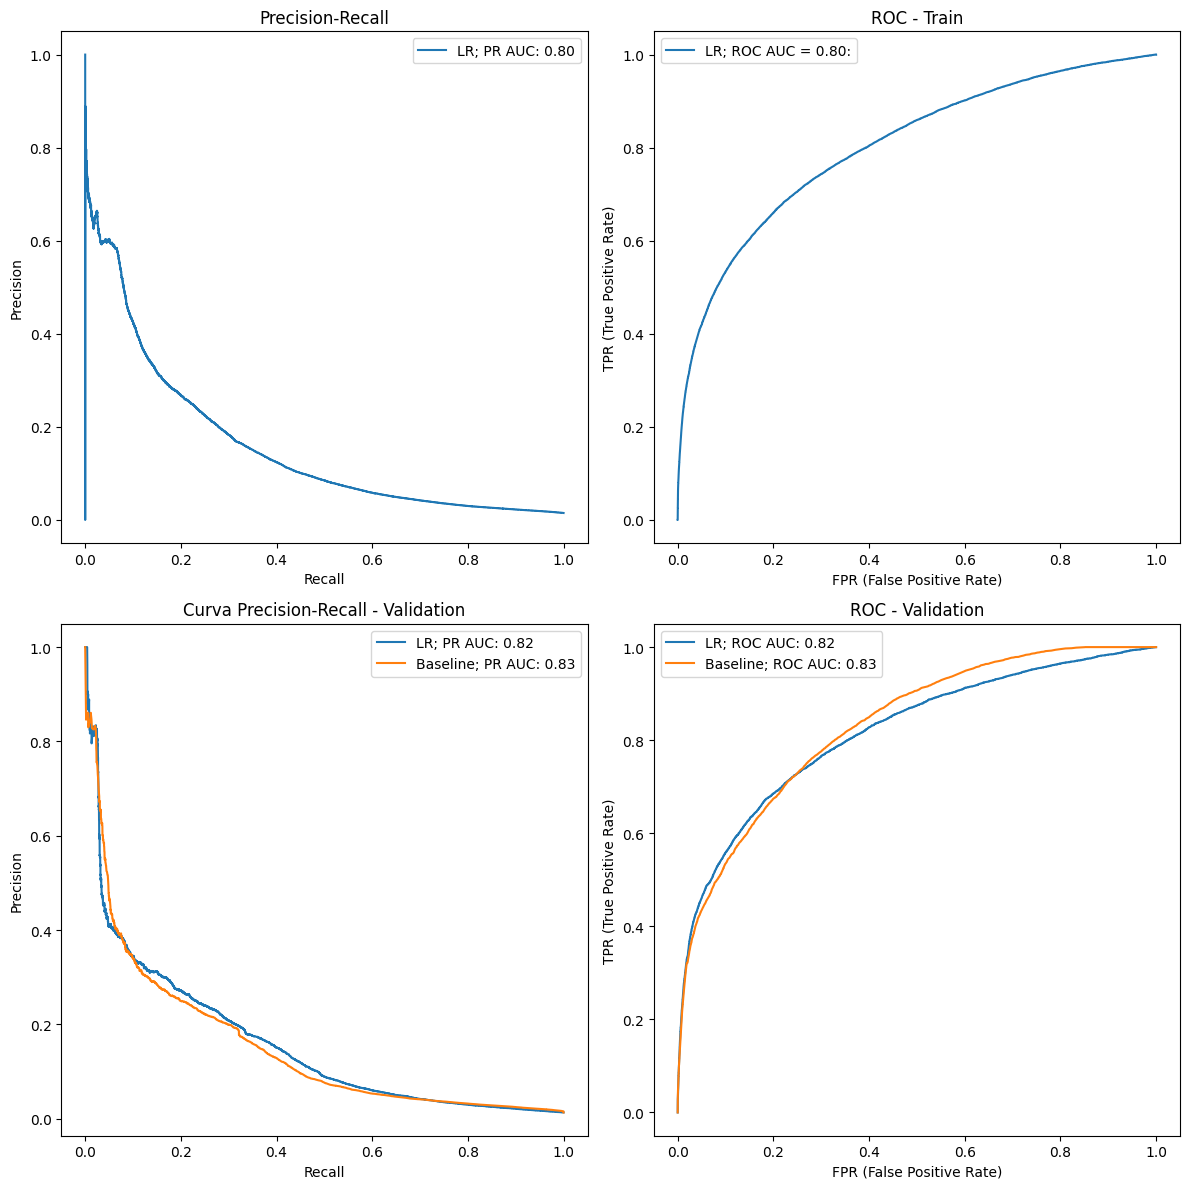

In [94]:
# I've seen in the documentation that there is a parameter that can have results in datasets with imbalanced classes:
# Model with penalty log loss (no regularization)

class_weight_dict = purch_5_prod["outcome"].value_counts(normalize=True).to_dict()

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
ax1, ax2, ax3, ax4 = axs.flatten()
lr = make_pipeline(
    StandardScaler(), LogisticRegression(penalty=None, class_weight=class_weight_dict)
)
# Training model
lr.fit(X_train[train_cols], y_train)
# Training curves
train_proba = lr.predict_proba(X_train[train_cols])[
    :, 1
]  # It will standardize the data using the mean and standard deviation from the training set.
precision_train, recall_train, _ = precision_recall_curve(y_train, train_proba)
pr_auc = roc_auc_score(y_train, train_proba)
ax1.plot(recall_train, precision_train, label=f"LR; PR AUC: {pr_auc:.2f}")
fpr_train, tpr_train, _ = roc_curve(y_train, train_proba)
roc_auc = roc_auc_score(y_train, train_proba)
ax2.plot(fpr_train, tpr_train, label=f"LR; ROC AUC = {roc_auc:.2f}:")
# Validation curves
val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
precision_val, recall_val, _ = precision_recall_curve(y_val, val_proba)
pr_auc = roc_auc_score(y_val, val_proba)
ax3.plot(recall_val, precision_val, label=f"LR; PR AUC: {pr_auc:.2f}")
fpr_val, tpr_val, _ = roc_curve(y_val, val_proba)
roc_auc = roc_auc_score(y_val, val_proba)
ax4.plot(fpr_val, tpr_val, label=f"LR; ROC AUC: {roc_auc:.2f}")

# Adding Baseline validation

# Validation curves
y_val_baseline = w1 * X_val["global_popularity"] + w2 * X_val["ordered_before"]
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_baseline)
pr_auc = roc_auc_score(y_val, y_val_baseline)
ax3.plot(recall_val, precision_val, label=f"Baseline; PR AUC: {pr_auc:.2f}")
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_baseline)
roc_auc = roc_auc_score(y_val, y_val_baseline)
ax4.plot(fpr_val, tpr_val, label=f"Baseline; ROC AUC: {roc_auc:.2f}")


ax1.set_title("Precision-Recall")
ax1.set_xlabel("Recall")
ax1.set_ylabel("Precision")
ax1.legend()

ax2.set_title("ROC - Train")
ax2.set_xlabel("FPR (False Positive Rate)")
ax2.set_ylabel("TPR (True Positive Rate)")
ax2.legend()


ax3.set_title("Curva Precision-Recall - Validation")
ax3.set_xlabel("Recall")
ax3.set_ylabel("Precision")
ax3.legend()


ax4.set_title("ROC - Validation")
ax4.set_xlabel("FPR (False Positive Rate)")
ax4.set_ylabel("TPR (True Positive Rate)")
ax4.legend()

plt.tight_layout()
plt.show()

It has no difference from the previous one

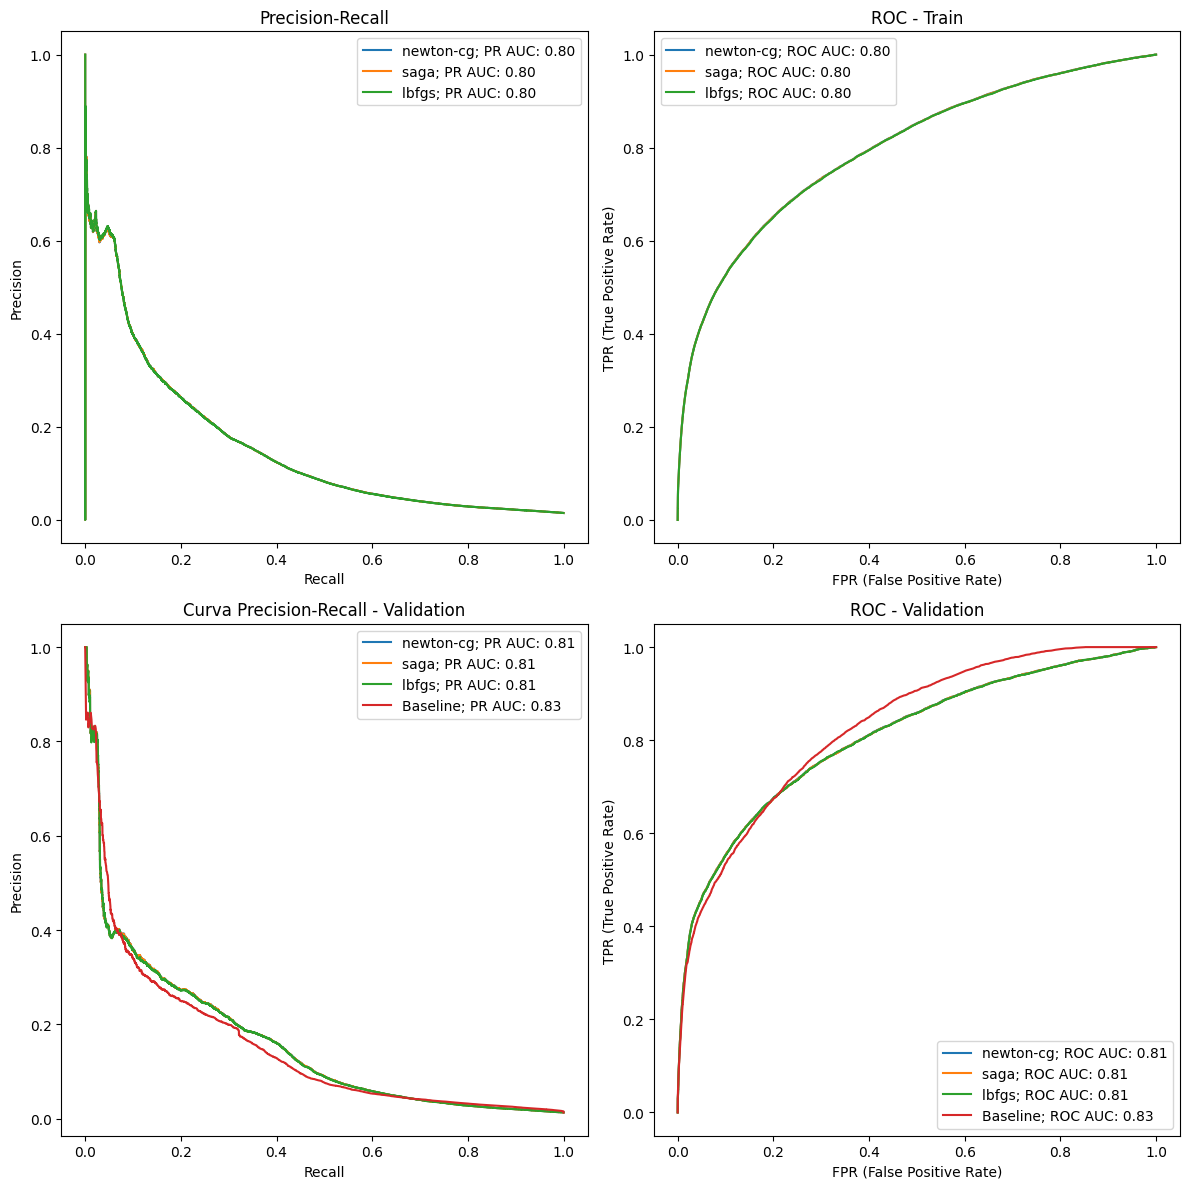

In [95]:
solvers = ["newton-cg", "saga", "lbfgs"]


fig, axs = plt.subplots(2, 2, figsize=(12, 12))
ax1, ax2, ax3, ax4 = axs.flatten()

for solver in solvers:

    lr = make_pipeline(
        StandardScaler(), LogisticRegression(penalty=None, solver=solver)
    )

    lr.fit(X_train[train_cols], y_train)
    train_proba = lr.predict_proba(X_train[train_cols])[:, 1]
    precision_train, recall_train, _ = precision_recall_curve(y_train, train_proba)
    pr_auc_train = roc_auc_score(y_train, train_proba)
    ax1.plot(
        recall_train, precision_train, label=f"{solver}; PR AUC: {pr_auc_train:.2f}"
    )

    fpr_train, tpr_train, _ = roc_curve(y_train, train_proba)
    roc_auc_train = roc_auc_score(y_train, train_proba)
    ax2.plot(fpr_train, tpr_train, label=f"{solver}; ROC AUC: {roc_auc_train:.2f}")

    val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
    precision_val, recall_val, _ = precision_recall_curve(y_val, val_proba)
    pr_auc_val = roc_auc_score(y_val, val_proba)
    ax3.plot(recall_val, precision_val, label=f"{solver}; PR AUC: {pr_auc_val:.2f}")

    fpr_val, tpr_val, _ = roc_curve(y_val, val_proba)
    roc_auc_val = roc_auc_score(y_val, val_proba)
    ax4.plot(fpr_val, tpr_val, label=f"{solver}; ROC AUC: {roc_auc_val:.2f}")

# Validation curves
y_val_baseline = w1 * X_val["global_popularity"] + w2 * X_val["ordered_before"]
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_baseline)
pr_auc = roc_auc_score(y_val, y_val_baseline)
ax3.plot(recall_val, precision_val, label=f"Baseline; PR AUC: {pr_auc:.2f}")
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_baseline)
roc_auc = roc_auc_score(y_val, y_val_baseline)
ax4.plot(fpr_val, tpr_val, label=f"Baseline; ROC AUC: {roc_auc:.2f}")


ax1.set_title("Precision-Recall")
ax1.set_xlabel("Recall")
ax1.set_ylabel("Precision")
ax1.legend()

ax2.set_title("ROC - Train")
ax2.set_xlabel("FPR (False Positive Rate)")
ax2.set_ylabel("TPR (True Positive Rate)")
ax2.legend()


ax3.set_title("Curva Precision-Recall - Validation")
ax3.set_xlabel("Recall")
ax3.set_ylabel("Precision")
ax3.legend()


ax4.set_title("ROC - Validation")
ax4.set_xlabel("FPR (False Positive Rate)")
ax4.set_ylabel("TPR (True Positive Rate)")
ax4.legend()

plt.tight_layout()
plt.show()

- The solvers don't affect the performance